## Table of contents:
* [First Bullet Header](#Imports)
* [Second Bullet Header](#Dataprep)

# Imports

In [141]:
import numpy as np
import pandas as pd
# matplotlib is the Python library for drawing diagrams
import matplotlib.pylab as plt
%matplotlib inline
# set the size of the diagrams
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,5
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [182]:
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(5).mean()
#     rolstd = timeseries.rolling(24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation from column: ' + title)
    plt.show(block=False)
    
def full_graph(predicted, title):
    predictionsArray = np.asarray(predicted)
    zerosArray = np.zeros(ts[['ice_extent']].values.size-len(predictionsArray.flatten()))
    cleanPrediction = pd.Series(np.concatenate((zerosArray,predictionsArray.flatten()))).replace(0,np.NaN)

    # plot
    plt.title(title)
    plt.plot(ts[['ice_extent']].values,marker='o', color='blue',label='Actual values')
    plt.plot(cleanPrediction,marker='o', color='red',label='Last 24 month prediction')
    plt.ylim([0,20])
    plt.legend()

    plt.show()  

## Dataprep

In [143]:
ts = pd.read_csv('./data/dataframe_yearly.csv', index_col=0).reset_index()
ts.rename(columns={'Year':'year'}, inplace=True)
ts.set_index('year', inplace=True)

In [144]:
ts

,mean_temp,ice_extent
year,,
1979,6.841667,12.349634
1980,6.625000,12.349545
1981,7.141667,12.147230
1982,6.816667,12.467336
1983,7.766667,12.353095
1984,7.291667,11.920382
1985,7.200000,12.015835
1986,7.533333,12.224548
1987,8.516667,12.183318


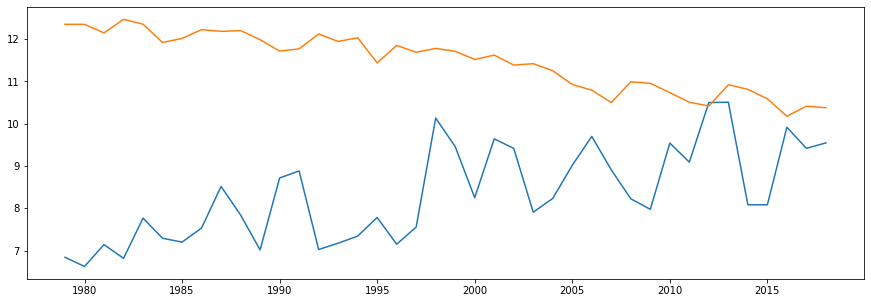

In [145]:
plt.plot(ts)

In [146]:
ts = ts

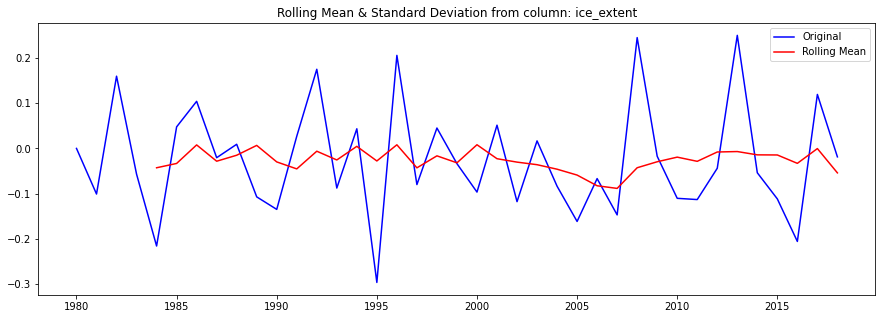

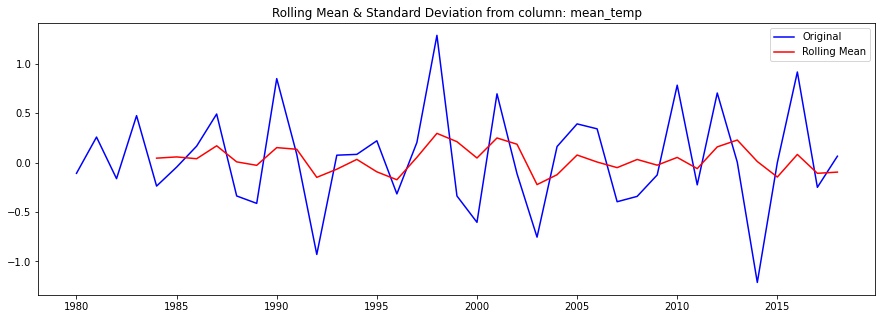

In [147]:
moving_avg = ts.rolling(2).mean()
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff

ts_moving_avg_diff.dropna(inplace=True)

test_stationarity(ts_moving_avg_diff[['ice_extent']], 'ice_extent')
test_stationarity(ts_moving_avg_diff[['mean_temp']], 'mean_temp')


Datasets are stationary now

# Cross validation setup

In [148]:
tscv = TimeSeriesSplit(n_splits = 8)
dataset = ts_moving_avg_diff

for train_index, test_index in tscv.split(dataset):
    if train_index.size > 20:

        # initialize cross validation train and test sets
        cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

        print("TRAIN:", train_index.size) # visiualize cross_validation structure for reference
        print("TEST:", test_index.size)
        print()

TRAIN: 23
TEST: 4

TRAIN: 27
TEST: 4

TRAIN: 31
TEST: 4

TRAIN: 35
TEST: 4



### VARMAX

#### Code for retrieving optimal values for pq parameters (20 min per permutation)

0.2049765042756947


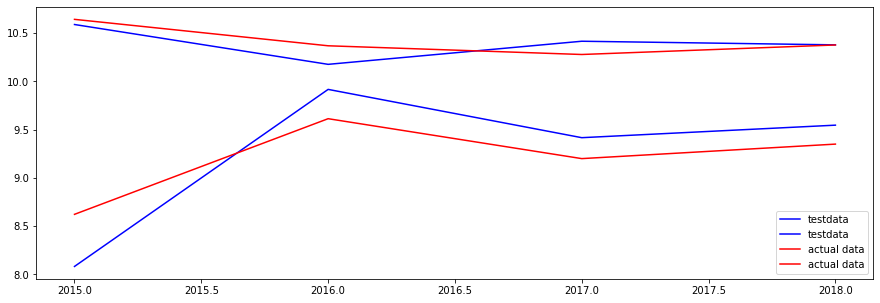

Wall time: 1.15 s


In [159]:
%%time
# singular test
import itertools
import warnings
import sys
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_absolute_error

# setting up values for displaying prediction of the last 2 years
data = dataset
test_size = 4
data_train = data[:-test_size]
data_test = data[-test_size:]

warnings.filterwarnings("ignore") # specify to ignore warning messages

# define model
model = VARMAX(data_train, order=(2, 0, 0))

# fit model
model_fit = model.fit()

# one step forecast
# yhat = model_fit.forecast(steps=data_test.size)
yhat = model_fit.predict(start=len(data_train), end=len(data_train)+test_size-1, dynamic=False)
yhat = yhat.set_index(data_test.index.values) 
data_test = data_test

mae = mean_absolute_error(yhat, data_test)

data_test = data_test + moving_avg[-4:]
yhat = yhat + moving_avg[-4:]


# plot
print(mae)
plt.plot(data_test, color='blue',label='testdata')
plt.plot(yhat, color='red', label='actual data')
plt.legend()
plt.show()

(0, 0)
Invalid VARMAX(p,q) specification; at least one p,q must be greater than zero.
(0, 1)
MAE: 0.08969775178281952
(0, 2)
MAE: 0.09084682789657494
(1, 0)
MAE: 0.10135843309426561
(1, 1)
MAE: 0.09507900628868592
(1, 2)
MAE: 0.0917881239462791
(2, 0)
MAE: 0.09667452611163505
(2, 1)
MAE: 0.1170920085746696
(2, 2)
MAE: 0.12352361784419548

Best MAE = 0.08969775178281952
(0, 1)


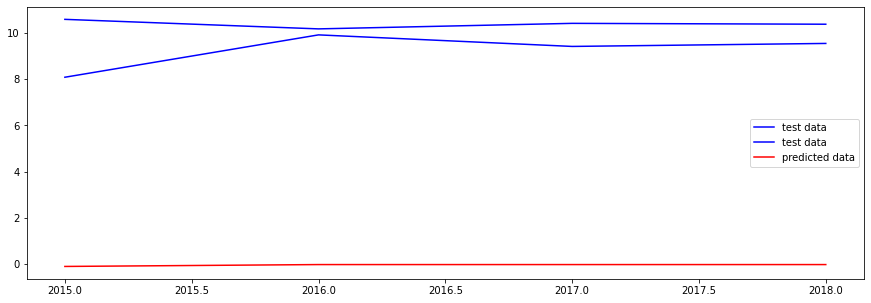

Wall time: 1min 6s


In [198]:
%%time
# ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
import itertools
import warnings
import sys
from sklearn.metrics import mean_absolute_error



# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pq = list(itertools.product(p, q))
best_pq = pq
best_mean_mae = np.inf
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pq:
    print(param)
    try:   # some parametercombinations might lead to crash, so catch exceptions and continue
        maes = []
        for train_index, test_index in tscv.split(dataset):
            if train_index.size > 20:
                # initialize cross validation train and test sets
                cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

                # build model
                model = VARMAX(data_train, order=(param))
                model_fit = model.fit()

                # make predictions
                predictions =  model_fit.forecast(steps=4, dynamic=False)
                prediction_values = predictions[['ice_extent']].values
                true_values = cv_test[['ice_extent']].values
                # error calc
                maes.append(mean_absolute_error(true_values, prediction_values))

        
        mean_mae = np.mean(maes)
        print('MAE: ' + str(mean_mae))    

        if mean_mae < best_mean_mae:
            best_mean_mae = mean_mae
            best_maes = maes
            best_pq = param
            best_predictions = prediction_values
    except Exception as e:
        print(e)
        continue
   
# plot
print()
print('Best MAE = ' + str(best_mean_mae))
print(best_pq)
plt.plot(data_test,color='blue',label='test data')
plt.plot(pd.DataFrame(best_predictions).set_index(keys=data_test.index), color='red', label='predicted data')
plt.legend()
plt.show()

# best range(0,2): (0, 2) = 1min = 0.091
# best range(0,7): ((0, 1)) = 42min = 0.0897


In [194]:
best_pq = (0,1)

----
IIII
Mean MAE: 0.091 x 1 000 000 km²
MAE of last prediction: 0.087 x 1 000 000 km²
Execution time: 7.834 seconds


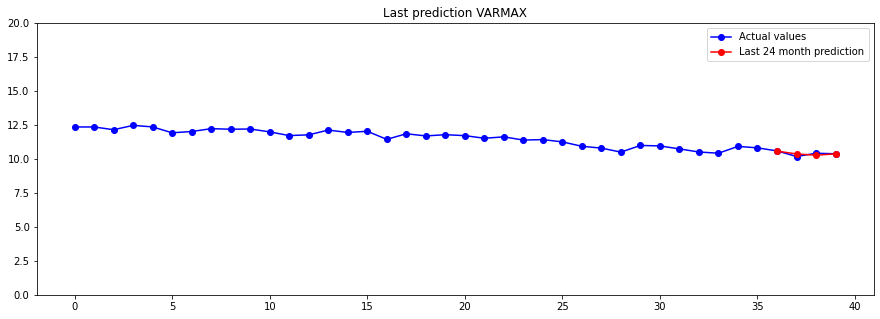

In [195]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_absolute_error
import timeit


start_time = timeit.default_timer()

warnings.filterwarnings("ignore") # specify to ignore warning messages

print("----")

maes = []

for train_index, test_index in tscv.split(dataset):
    if train_index.size > 20:
        # initialize cross validation train and test sets
        cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

        # build model
        model = VARMAX(data_train, order=(best_pq))
        model_fit = model.fit()

        # make predictions
        predictions =  model_fit.forecast(steps=4, dynamic=False)
        prediction_values = predictions[['ice_extent']].values
        true_values = cv_test[['ice_extent']].values
        # error calc
        maes.append(mean_absolute_error(true_values, prediction_values))

        print("I",end="")
    
    
# last actual prediction 
last_prediction_VARMAX = prediction_values + moving_avg.dropna().iloc[test_index]

time_VARMAX = timeit.default_timer() - start_time
mae_mean = np.mean(maes)
MAE_VARMAX = mae_mean
last_MAE_VARMAX = maes[-1]

print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_VARMAX)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_VARMAX)
print('Execution time: %.3f seconds' % time_VARMAX)
full_graph(last_prediction_VARMAX[['ice_extent']], 'Last prediction VARMAX')

### LSTM

In [28]:
tsmvm

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08,52.502651,53.797798,51.334253,52.434573,52.434573,1.491568e+07
2004-09,55.779496,57.245667,55.271401,56.402162,56.402162,1.016682e+07
2004-10,75.960519,77.978432,74.410615,76.329374,76.329374,2.457433e+07
2004-11,88.750200,90.639783,86.757195,88.416214,88.416214,2.653653e+07
2004-12,90.359719,91.655997,89.427305,90.545612,90.545612,1.326237e+07
...,...,...,...,...,...,...
2020-03,1183.330916,1216.323952,1151.405090,1188.394098,1188.394098,3.245095e+06
2020-04,1234.962623,1252.050618,1215.606329,1234.140480,1234.140480,2.206338e+06
2020-05,1377.211841,1395.460345,1364.088348,1381.113751,1381.113751,1.594240e+06


In [29]:
values = reframed.values
n_train_hours = 365
train = values[:n_train_hours, :]

NameError: name 'reframed' is not defined

In [30]:
#scaler wordt gebruikt om de features op een gelijkwaardige schaal te krijgen 
#en zal ervoor zorgen dat gradient descent beter werkt

In [31]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_test_rows = 7
train = values[:-n_test_rows, :]
test = values[-n_test_rows:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

NameError: name 'n_hours' is not defined

In [ ]:
print()
rmspe_LSTM = calc_rmspe(inv_y, inv_yhat)
print('Test RMSPE: %.3f' % rmspe_LSTM)
r2_LSTM = r2_score(inv_y, inv_yhat)
print('R square: ' + str(r2_LSTM))  

### Polynomial

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

# Prepare variables that keep track of the best fitting polynomial
BestRMSPE = float('inf')
BestIRMSPE = 1

for i in range(1,10):
    poly = PolynomialFeatures(degree=i)   
    
    # Create PolynomialFeatures with the i'th degree
    poly = PolynomialFeatures(degree=i)

    # Fit the inputdata from your trainingsset to the polynomial
    poly_variables = poly.fit_transform(train_X)
    
    # Create the model and fit it to the transformed inputdata and your expected outputdata from the trainingsdata
    regression = linear_model.LinearRegression()
    model = regression.fit(train_X, train_y)
    
    
    test_X_transform = poly.fit_transform(test_X)
    pred_y = model.predict(test_X_transform)
    
    RMSPE_test = calc_rmspe(test_y, pred_y)
    print(i)
    print(RMSPE_test)
    
    # Update best fit
    if BestRMSPE > RMSPE_test:
        BestRMSPE = RMSPE_test
        BestRMSPEi = i

In [ ]:
rmspe_LSTM

In [ ]:
plt.plot(pred_y)
plt.plot(test_y)

In [ ]:
# prepare a list of ml models
def get_models(models=dict()):
	# linear models
	models['lr'] = LinearRegression()
	models['lasso'] = Lasso()
	models['ridge'] = Ridge()
	models['en'] = ElasticNet()
	models['huber'] = HuberRegressor()
	models['llars'] = LassoLars()
	models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
	models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
	print('Defined %d models' % len(models))
	return models

In [ ]:
# evaluate linear algorithms
from numpy import load
from numpy import loadtxt
from numpy import nan
from numpy import isnan
from numpy import count_nonzero
from numpy import unique
from numpy import array
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor

# split the dataset by 'chunkID', return a list of chunks
def to_chunks(values, chunk_ix=0):
	chunks = list()
	# get the unique chunk ids
	chunk_ids = unique(values[:, chunk_ix])
	# group rows by chunk id
	for chunk_id in chunk_ids:
		selection = values[:, chunk_ix] == chunk_id
		chunks.append(values[selection, :])
	return chunks

# return true if the array has any non-nan values
def has_data(data):
	return count_nonzero(isnan(data)) < len(data)

# return a list of relative forecast lead times
def get_lead_times():
	return [1, 2, 3, 4, 5, 10, 17, 24, 48, 72]

# fit a single model
def fit_model(model, X, y):
	# clone the model configuration
	local_model = clone(model)
	# fit the model
	local_model.fit(X, y)
	return local_model

# fit one model for each variable and each forecast lead time [var][time][model]
def fit_models(model, train):
	# prepare structure for saving models
	models = [[list() for _ in range(train.shape[1])] for _ in range(train.shape[0])]
	# enumerate vars
	for i in range(train.shape[0]):
		# enumerate lead times
		for j in range(train.shape[1]):
			# get data
			data = train[i, j]
			X, y = data[:, :-1], data[:, -1]
			# fit model
			local_model = fit_model(model, X, y)
			models[i][j].append(local_model)
	return models

# return forecasts as [chunks][var][time]
def make_predictions(models, test):
	lead_times = get_lead_times()
	predictions = list()
	# enumerate chunks
	for i in range(test.shape[0]):
		# enumerate variables
		chunk_predictions = list()
		for j in range(test.shape[1]):
			# get the input pattern for this chunk and target
			pattern = test[i,j]
			# assume a nan forecast
			forecasts = array([nan for _ in range(len(lead_times))])
			# check we can make a forecast
			if has_data(pattern):
				pattern = pattern.reshape((1, len(pattern)))
				# forecast each lead time
				forecasts = list()
				for k in range(len(lead_times)):
					yhat = models[j][k][0].predict(pattern)
					forecasts.append(yhat[0])
				forecasts = array(forecasts)
			# save forecasts for each lead time for this variable
			chunk_predictions.append(forecasts)
		# save forecasts for this chunk
		chunk_predictions = array(chunk_predictions)
		predictions.append(chunk_predictions)
	return array(predictions)

# convert the test dataset in chunks to [chunk][variable][time] format
def prepare_test_forecasts(test_chunks):
	predictions = list()
	# enumerate chunks to forecast
	for rows in test_chunks:
		# enumerate targets for chunk
		chunk_predictions = list()
		for j in range(3, rows.shape[1]):
			yhat = rows[:, j]
			chunk_predictions.append(yhat)
		chunk_predictions = array(chunk_predictions)
		predictions.append(chunk_predictions)
	return array(predictions)

# calculate the error between an actual and predicted value
def calculate_error(actual, predicted):
	# give the full actual value if predicted is nan
	if isnan(predicted):
		return abs(actual)
	# calculate abs difference
	return abs(actual - predicted)

# evaluate a forecast in the format [chunk][variable][time]
def evaluate_forecasts(predictions, testset):
	lead_times = get_lead_times()
	total_mae, times_mae = 0.0, [0.0 for _ in range(len(lead_times))]
	total_c, times_c = 0, [0 for _ in range(len(lead_times))]
	# enumerate test chunks
	for i in range(len(test_chunks)):
		# convert to forecasts
		actual = testset[i]
		predicted = predictions[i]
		# enumerate target variables
		for j in range(predicted.shape[0]):
			# enumerate lead times
			for k in range(len(lead_times)):
				# skip if actual in nan
				if isnan(actual[j, k]):
					continue
				# calculate error
				error = calculate_error(actual[j, k], predicted[j, k])
				# update statistics
				total_mae += error
				times_mae[k] += error
				total_c += 1
				times_c[k] += 1
	# normalize summed absolute errors
	total_mae /= total_c
	times_mae = [times_mae[i]/times_c[i] for i in range(len(times_mae))]
	return total_mae, times_mae

# summarize scores
def summarize_error(name, total_mae):
	print('%s: %.3f MAE' % (name, total_mae))

# prepare a list of ml models
def get_models(models=dict()):
	# linear models
	models['lr'] = LinearRegression()
	models['lasso'] = Lasso()
	models['ridge'] = Ridge()
	models['en'] = ElasticNet()
	models['huber'] = HuberRegressor()
	models['llars'] = LassoLars()
	models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
	models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
	print('Defined %d models' % len(models))
	return models

# evaluate a suite of models
def evaluate_models(models, train, test, actual):
	for name, model in models.items():
		# fit models
		fits = fit_models(model, train)
		# make predictions
		predictions = make_predictions(fits, test)
		# evaluate forecast
		total_mae, _ = evaluate_forecasts(predictions, actual)
		# summarize forecast
		summarize_error(name, total_mae)

# load supervised datasets
train = load('AirQualityPrediction/supervised_train.npy', allow_pickle=True)
test = load('AirQualityPrediction/supervised_test.npy', allow_pickle=True)
print(train.shape, test.shape)
# load test chunks for validation
testset = loadtxt('AirQualityPrediction/naive_test.csv', delimiter=',')
test_chunks = to_chunks(testset)
actual = prepare_test_forecasts(test_chunks)
# prepare list of models
models = get_models()
# evaluate models
evaluate_models(models, train, test, actual)

### Evaluation

In [ ]:
print('VARMAX')
print('Test RMSPE: %.3f' % rmspe_VARMAX)
print('R square: ' + str(r2_VARMAX))  
print()

print('LSTM')
print('Test RMSPE: %.3f' % rmspe_LSTM)
print('R square: ' + str(r2_LSTM))  
print()